# Resumo do Capítulo 6: Implementação de Filtros de Tempo Discreto

O Capítulo 6 aborda a implementação prática de filtros digitais, considerando:
1. **Estruturas de Realização**:
   - **Filtros IIR**: Forma direta I/II, cascata, paralela e lattice.
   - **Filtros FIR**: Forma direta, cascata, fase linear e amostragem em frequência.
2. **Efeitos da Precisão Finita**:
   - Representação numérica (ponto fixo e flutuante).
   - Erros de quantização (truncamento e arredondamento).
   - Sensibilidade de coeficientes e estabilidade.
3. **Análise com MATLAB**:
   - Funções para conversão entre estruturas.
   - Simulação de quantização e análise de erros.


## Simulações em Python
Abaixo estão implementações-de alguns exemplos do capítulo adaptadas para Python usando `numpy`, `scipy` e `matplotlib`.


#### 1. Conversão para Forma em Cascata (Exemplo 6.1)


Seções de Segunda Ordem (SOS):
[[ 6.25000000e-02  2.06912365e-16  5.62500000e-01  1.00000000e+00
  -2.50000000e-01 -1.25000000e-01]
 [ 1.00000000e+00 -3.00000000e+00  2.00000000e+00  1.00000000e+00
   1.00000000e+00  5.00000000e-01]]


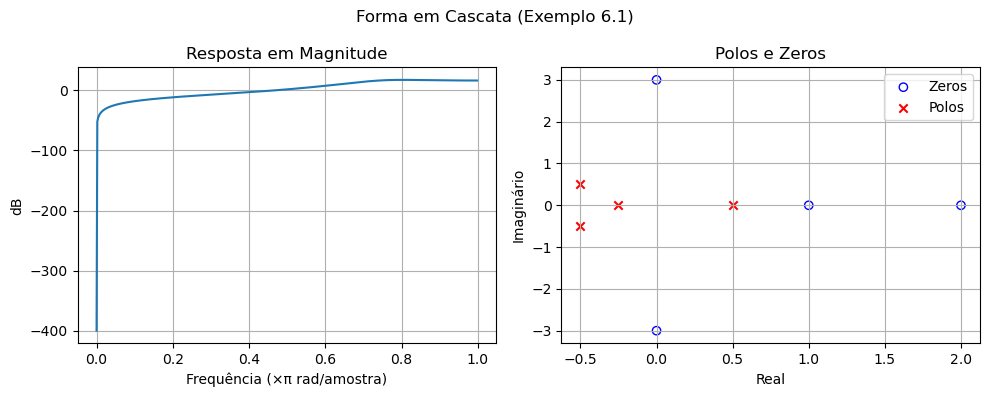

In [4]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Coeficientes do filtro (Exemplo 6.1)
b = np.array([1, -3, 11, -27, 18])  # Numerador
a = np.array([16, 12, 2, -4, -1])   # Denominador

# Normalizar coeficientes (a[0] = 1)
b_norm = b / a[0]
a_norm = a / a[0]

# Converter para forma em cascata (SOS)
sos = signal.tf2sos(b_norm, a_norm)
print("Seções de Segunda Ordem (SOS):")
print(sos)

# Plotar diagrama de polos e zeros
plt.figure(figsize=(10, 4))
plt.suptitle("Forma em Cascata (Exemplo 6.1)")

# Resposta em frequência
w, h = signal.freqz(b, a)
plt.subplot(121)
plt.plot(w/np.pi, 20 * np.log10(np.abs(h) + 1e-20))
plt.title("Resposta em Magnitude")
plt.xlabel("Frequência (×π rad/amostra)")
plt.ylabel("dB")
plt.grid(True)

# Diagrama de polos e zeros
plt.subplot(122)
z, p, _ = signal.tf2zpk(b, a)
plt.scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='b', label='Zeros')
plt.scatter(np.real(p), np.imag(p), marker='x', color='r', label='Polos')
plt.title("Polos e Zeros")
plt.xlabel("Real")
plt.ylabel("Imaginário")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 2. Estrutura Lattice para Filtro FIR (Exemplo 6.8)

Coeficientes de Reflexão (k): [0.25       0.5        0.33333333]


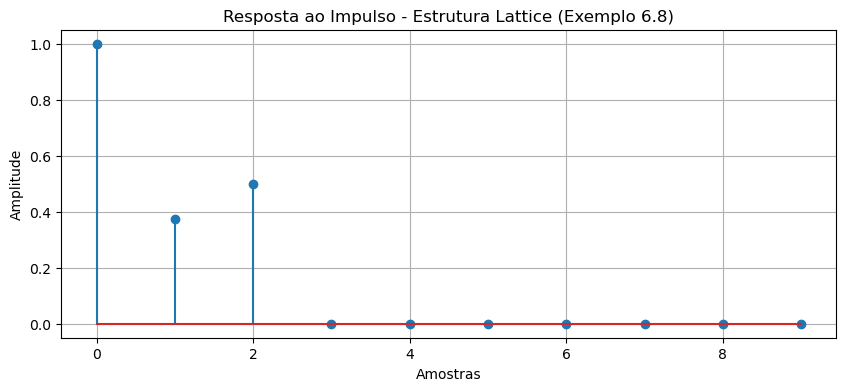

In [6]:
def dir2lat(b):
    """Converte coeficientes FIR direto para reflexão (lattice)"""
    k = np.zeros(len(b)-1)
    a = b.copy() / b[0]
    
    for m in range(len(b)-1, 0, -1):
        k[m-1] = a[m]
        a = (a - k[m-1] * a[::-1]) / (1 - k[m-1]**2)
        a = a[:-1]
    return k

# Coeficientes do filtro FIR
b = np.array([2, 13/12, 5/4, 2/3])
k = dir2lat(b)
print("Coeficientes de Reflexão (k):", k)

# Implementação do filtro lattice
def latcfilt(k, x):
    N = len(x)
    f = np.zeros((len(k), N))
    g = np.zeros((len(k), N))
    
    f[0] = x
    g[0] = x
    
    for i in range(1, len(k)):
        f[i] = f[i-1] + k[i-1] * np.roll(g[i-1], 1)
        g[i] = k[i-1] * f[i-1] + np.roll(g[i-1], 1)
    return f[-1]

# Resposta ao impulso
impulse = np.zeros(10)
impulse[0] = 1
h_lat = latcfilt(k, impulse)

plt.figure(figsize=(10, 4))
plt.stem(h_lat) 
plt.title("Resposta ao Impulso - Estrutura Lattice (Exemplo 6.8)")
plt.xlabel("Amostras")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

#### 3. Efeito da Quantização de Coeficientes (Exemplo 6.26)

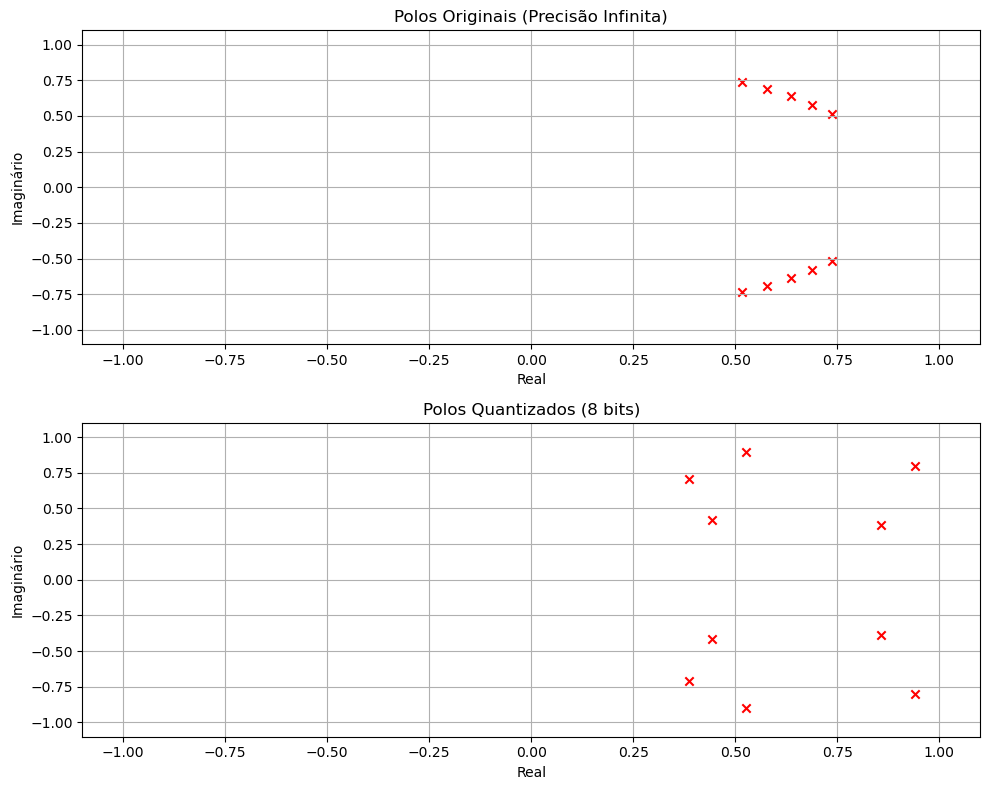

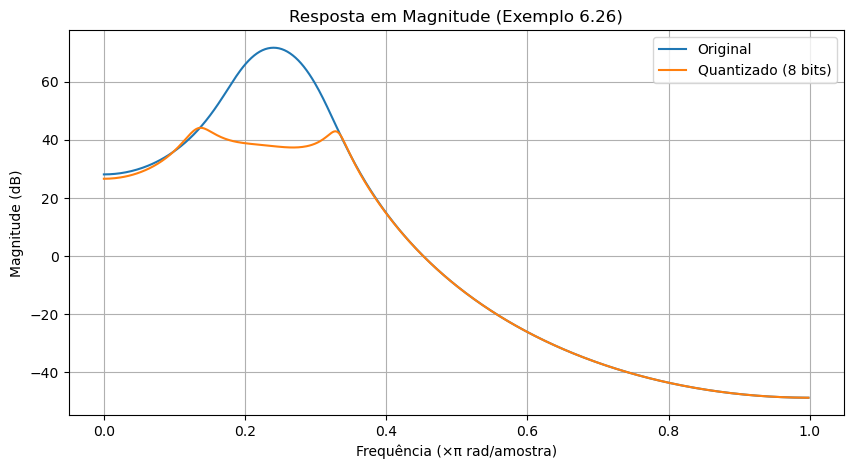

In [8]:
def quantize_coeff(coeff, word_length, frac_bits):
    """Quantiza coeficientes para ponto fixo"""
    scale = 2**frac_bits
    q_coeff = np.round(coeff * scale) / scale
    return q_coeff

# Projetar filtro IIR (10 polos agrupados)
r = 0.9  # Raio
theta = np.pi * np.array([-55, -50, -45, -40, -35, 35, 40, 45, 50, 55]) / 180
poles = r * np.exp(1j * theta)
b = np.array([1])  # Numerador
a = np.poly(poles) # Denominador

# Quantizar coeficientes (8 bits)
word_length = 8
frac_bits = word_length - 1  # Considera bit de sinal
a_quant = quantize_coeff(a, word_length, frac_bits)

# Plotar polos
plt.figure(figsize=(10, 8))
plt.subplot(211)
z, p, _ = signal.tf2zpk(b, a)
plt.scatter(np.real(p), np.imag(p), marker='x', color='r')
plt.title("Polos Originais (Precisão Infinita)")
plt.xlabel("Real")
plt.ylabel("Imaginário")
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
plt.grid(True)

plt.subplot(212)
_, p_quant, _ = signal.tf2zpk(b, a_quant)
plt.scatter(np.real(p_quant), np.imag(p_quant), marker='x', color='r')
plt.title(f"Polos Quantizados ({word_length} bits)")
plt.xlabel("Real")
plt.ylabel("Imaginário")
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
plt.grid(True)
plt.tight_layout()
plt.show()

# Comparar respostas em frequência
w, h = signal.freqz(b, a)
_, h_quant = signal.freqz(b, a_quant)

plt.figure(figsize=(10, 5))
plt.plot(w/np.pi, 20 * np.log10(np.abs(h)), label='Original')
plt.plot(w/np.pi, 20 * np.log10(np.abs(h_quant)), label=f'Quantizado ({word_length} bits)')
plt.title("Resposta em Magnitude (Exemplo 6.26)")
plt.xlabel("Frequência (×π rad/amostra)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.grid(True)
plt.show()



# 🎥 Vídeos sobre Filtros Digitais FIR e IIR

## Vídeo 1 – Filtros Digitais (UNIVESP)
https://youtu.be/CaXR0WDB-Ww?si=jwJMxISzX8ZILk-C

## Vídeo 2 – Filtros FIR (UNIVESP)
https://youtu.be/5LTRzMNpIPo?si=Snhf4ORbfv4WEM2D

## Vídeo 3 – Filtros IIR (UNIVESP)
https://youtu.be/V-hSvPQm-ME?si=Yn5ljM-K8s5ukCPi

## Vídeo 4 – Projeto de Filtros (UNIVESP)
https://youtu.be/rgcbsLyf9mM?si=HPAAMyfTfOXQkgmL

## Vídeo 5 – Projetanto Filtros FIR (UNIVESP)
https://youtu.be/FHHYfsVyRIE?si=7u-jgppVOdxYb8EY

## Vídeo 6 – Projetanto Filtros IIR (UNIVESP)
https://youtu.be/jLnhm4JgmCw?si=T1s3o8v-h4K42ZD_